#Implementing a conditional GAN (CGAN)
A deep convolutional GAN doesn't control the class of generated samples. To be able to control what is generated, the GAN output needs to be conditioned on a semantic input from the target. The difference between Semi-supervised GAN and CGAN regards input handling, whith use of embedding and element-wise multiplication to combine the random noise vector and the label into a joint representation.

In [ ]:
# Import dependencies
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D # UpSampling2D alternative to Conv2DTranspose, no 'filters' and 'kernel_size'
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

In [ ]:
# Save model
import os
if not os.path.isdir("images"):
    os.mkdir("images")
if not os.path.isdir("saved_model"):
    os.mkdir("saved_model")
print(os.listdir("."))

['.config', 'saved_model', 'images', 'sample_data']


In [ ]:
class CGAN():
    def __init__(self):

        # Input shapes
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        # Build and compile the discriminator
        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses, optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
        # The generator expects a random noise vector and a target label to generate a corresponding label digit 
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])
        
        # Keep discriminator parameters constant during generator training (before compiling the combined model)
        self.discriminator.trainable = False

        # The discriminator takes generated images as input to determine validity
        valid, target_label = self.discriminator(img)

        # The combined generator/discriminator model trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses, optimizer=optimizer)
    
    # ----------------------
    # CGAN Generator network
    # ----------------------

    def build_generator(self):

        model = Sequential()
        # Reshape input into 7x7x128 tensor via a fully connected layer
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        # Transposed convolutional layer
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        # Transposed convolutional layer from 7x7x128 to 14x14x64 tensor
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        # Convolutional layer from 14x14x64 to 28x28x1 tensor
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))
        #model.summary()

        # -----------------
        # Handles generator input noize and its label embedding
        # -----------------

        # Random noise vector
        noise = Input(shape=(self.latent_dim,))
        # Conditioning label: Specify the integer (0-9) to generate
        label = Input(shape=(1,), dtype='int32')
        # Label embedding: Turn label into a dense vector
        label_embedding = Embedding(self.num_classes, 100)(label)
        # Flatten embedding
        label_embedding = Flatten()(label_embedding)
        # Element-wise product of noise vector and label embedding
        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    # --------------------------
    # CGAN Discriminator network
    # --------------------------

    def build_discriminator(self):

        model = Sequential()
        # Convolutional layer from 28x28x2 (joint representation/concatenated image-label pair) into 14x14x16 tensor
        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        # Convolutional layer from 14x14x16 into 7x7x32 tensor
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        # Convolutional layer from 7x7x32 into 3x3x64 tensor
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        # Convolutional layer from 3x3x64 into 3x3x128 tensor
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        #model.summary()

        # ---------------------
        # Handles discriminator input image and its label embedding
        # ---------------------

        # Input image
        img = Input(shape=self.img_shape)
        # Extract feature representation
        features = model(img)
        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [validity, label])

    # ------------------
    # CGAN training loop
    # ------------------

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the MNIST dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Rescale [0, 255] grayscale pixel values to [-1, 1]
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Labels (1s) for valid images
        valid = np.ones((batch_size, 1))
        # Labels (0s) for fake images
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # --------------------
            #  Train Discriminator
            # --------------------

            # Get a random batch of real images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise for generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Digits labels for the generator to create an image representation
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a batch of fake images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels: 0-9 for valid images and 10 for fake
            img_labels = y_train[idx]
            fake_labels = 10 * np.ones(img_labels.shape)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ----------------
            #  Train Generator
            # ----------------

            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % 
                   (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

            # Save generated image samples
            if epoch % sample_interval == 0:
                self.save_model()
                self.sample_images(epoch)
                print ("%d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % 
                       (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))

    # -------------------------
    #  Display generated images
    # -------------------------

    def sample_images(self, epoch):
        # Get image labels 0-9
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        # Sample random noise
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale image pixel values to [0, 1]
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        # Set image grid  
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

    # -----------
    #  Save model
    # -----------

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

In [ ]:
cgan = CGAN()
cgan.train(epochs=3000, batch_size=32, sample_interval=500)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
504 [D loss: 1.836164, acc.: 62.50%, op_acc: 60.94%] [G loss: 2.872828]
1/1 [==============================] - 0s 24ms/step
505 [D loss: 1.628643, acc.: 62.50%, op_acc: 64.06%] [G loss: 2.930629]
1/1 [==============================] - 0s 57ms/step
506 [D loss: 2.015724, acc.: 62.50%, op_acc: 45.31%] [G loss: 2.661850]
1/1 [==============================] - 0s 35ms/step
507 [D loss: 1.981670, acc.: 53.12%, op_acc: 54.69%] [G loss: 2.619371]
1/1 [==============================] - 0s 33ms/step
508 [D loss: 1.759757, acc.: 68.75%, op_acc: 53.12%] [G loss: 2.672801]
1/1 [==============================] - 0s 44ms/step
509 [D loss: 1.979155, acc.: 50.00%, op_acc: 54.69%] [G loss: 2.712989]
1/1 [==============================] - 0s 37ms/step
510 [D loss: 2.214094, acc.: 45.31%, op_acc: 46.88%] [G loss: 2.456467]
1/1 [==============================] - 0s 27ms/step
511 [D loss: 2.156208, acc.: 

In [ ]:
import imageio
file_names = sorted((fn for fn in os.listdir('./images') if fn.endswith('.png')))
images = []
for filename in file_names:
    images.append(imageio.imread("./images/" + filename))
kargs = { 'duration': .1 }
imageio.mimsave('./result.gif', images, **kargs)

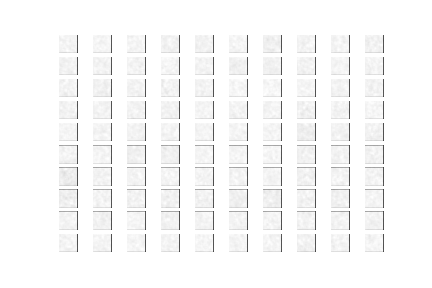

In [ ]:
from IPython.display import Image
Image(filename="result.gif")

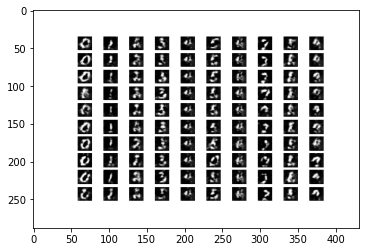

In [ ]:
plt.imshow(plt.imread("./images/"+file_names[-1]));

# References
For more info see https://github.com/kaggle/docker-python